In [71]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [72]:
def create_placeholders(n_x):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """
    
    X = tf.placeholder(tf.float32, shape=(None, n_x), name="X")
    Y = tf.placeholder(tf.int64, shape=(None,), name="Y")
    training = tf.placeholder_with_default(False, shape=(), name='training')  # istraining flag for batch_normalization()
    
    return X, Y, training

In [73]:
def forward_propagation(X, layer_hidden_nums, training):
    """
    Implements the forward propagation for the model
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)

    Returns:
    Z5 -- the output of the last LINEAR unit
    """
    he_init = tf.contrib.layers.variance_scaling_initializer()
    
    A = X
    for layer_index, layer_neurons in enumerate(layer_hidden_nums[:-1]):
        Z = tf.layers.dense(inputs=A, units=layer_neurons, kernel_initializer=he_init, name="hidden%d" % (layer_index + 1))
        Z_nor = tf.layers.batch_normalization(Z, training=training, momentum=0.9)
        A = tf.nn.elu(Z_nor)
        
    Z_output = tf.layers.dense(inputs=A, units=layer_hidden_nums[-1], kernel_initializer=he_init, name="hidden%d" % (len(layer_hidden_nums)))
    Z_output_nor = tf.layers.batch_normalization(Z_output, training=training, momentum=0.9)
    
    return Z_output_nor

In [74]:
def compute_cost(Z_output, Y):
    """
    Computes the cost
    
    Arguments:
    Z_output -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, layer_hidden_nums[4]=1)
    Y -- label, size of (number of examples, 1)
    
    Returns:
    cost - Tensor of the cost function
    """

    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=Z_output))   
    return cost

In [80]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001,
          num_epochs=20, minibatch_size=32, print_cost=True):
    (m, n_x) = X_train.shape
    costs = []                                        # To keep track of the cost
    X, Y, training = create_placeholders(n_x)
    layer_hidden_nums = [200, 100, 50, 25, 5]
    Z5 = forward_propagation(X, layer_hidden_nums, training)
    cost = compute_cost(Z5, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    correct = tf.nn.in_top_k(Z5, Y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        # Run the initialization
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0
            shuffled_idx = np.random.permutation(m)
            num_minibatches = X_train.shape[0] // minibatch_size
            batches = np.array_split(shuffled_idx, num_minibatches)
            
            for batch in batches:
                X_batch, Y_batch = X_train[batch], Y_train[batch]
                # for training, need to set flag training of batch_normalization() to true
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={training: True, X: X_batch, Y: Y_batch})  
                epoch_cost += minibatch_cost / num_minibatches
                
            if epoch % 10 == 0:
                acc_train = accuracy.eval(feed_dict={X: X_train, Y: Y_train})  # for testing, leave training param for batch_normalization() to false
                acc_test = accuracy.eval(feed_dict={X: X_test, Y: Y_test})
                print(epoch, "Train accuracy: ", acc_train, "Test accuracy: ", acc_test)
            # Print the cost every epoch
            if print_cost is True and epoch % 20 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost is True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        save_path = saver.save(sess, "C:\Boyuan\MyPython\SavedModel\FiveLayerNNForMNist\my_model_final.ckpt")

In [76]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")
X_train1 = mnist.train.images[mnist.train.labels < 5]
y_train1 = mnist.train.labels[mnist.train.labels < 5]
X_valid1 = mnist.validation.images[mnist.validation.labels < 5]
y_valid1 = mnist.validation.labels[mnist.validation.labels < 5]
X_test1 = mnist.test.images[mnist.test.labels < 5]
y_test1 = mnist.test.labels[mnist.test.labels < 5]

Extracting /tmp/data/train-images-idx3-ubyte.gz


Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
X_train1.shape

(28038, 784)

In [3]:
len(X_train1)

28038

In [10]:
y_train1.shape

(28038,)

In [41]:
y_train1

array([3, 4, 1, ..., 2, 1, 3], dtype=uint8)

0 Train accuracy:  0.960019 Test accuracy:  0.964779
Cost after epoch 0: 0.502825


10 Train accuracy:  0.989621 Test accuracy:  0.983849


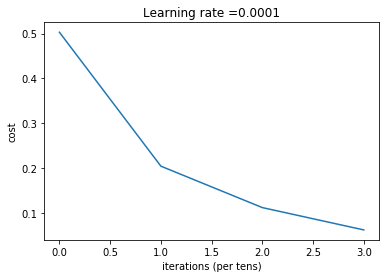

In [81]:
reset_graph()

model(X_train1, y_train1, X_test1, y_test1)